# PACS Dataset

- download link: https://drive.google.com/uc?id=1JFr8f805nMUelQWWmfnJR3y4_SYoN5Pd
- Subpopulation size
    - Majority: photo domain (1200 images for 7 classes in total)
    - Minority: cartoon domain (600 images for 7 classes in total)

In [1]:
ROOT_PATH = 'kfold' # downloaded dataset root path
EXP_ROOT_PATH = '../../experiments/pacs' # experiment root path

In [2]:
import os
import shutil
import numpy as np
import glob
from torchvision.datasets import ImageFolder
import random
from tqdm import tqdm
import PIL
import matplotlib.pyplot as plt

In [4]:
num_class = 7
cls_name = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
domains = sorted(entry.name for entry in os.scandir(ROOT_PATH) if entry.is_dir())
domain_to_dataset = {domain: ImageFolder(root=os.path.join(ROOT_PATH, domain)) for domain in domains}

## Dataset samples

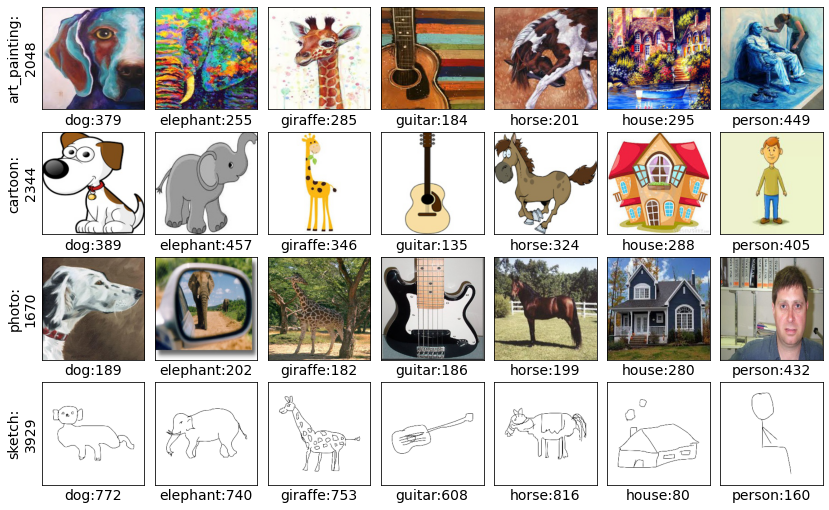

In [5]:
show_samples = {}
sample_num = {}
for d in domains:
    show_samples[d] = [ [] for i in range(num_class) ]
    sample_num[d] = [ 0 for i in range(num_class) ]
    for sample in domain_to_dataset[d].samples:
        show_samples[d][sample[1]].append(sample[0]) if len(show_samples[d][sample[1]]) < 1 else None
        sample_num[d][sample[1]] += 1
        
plt.figure(figsize=(14,9))
for i, (d,v) in enumerate(show_samples.items()):
    for ci, cls in enumerate(v):
        pil_img = PIL.Image.open(cls[0])
        plt.subplot(len(show_samples), len(v), i*len(v)+ci+1)
        plt.imshow(pil_img)
        plt.ylabel(d+':\n'+str(len(domain_to_dataset[d].samples)), fontsize=14) if ci==0 else None
        plt.xlabel(cls_name[ci]+':'+str(sample_num[d][ci]),fontsize=14)
        plt.xticks([])
        plt.yticks([])
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.show()

## Prepare data

In [ ]:
major_domain = 'photo'
minor_domain = 'cartoon'
TRAIN_NUM = [1200, 600] # [majority, minority] 
VAL_NUM   = [400, 400] # [majority, minority] 
print('majority : minority = {:.2f} : {:.2f}'.format(\
    TRAIN_NUM[0]/(TRAIN_NUM[0]+TRAIN_NUM[1]), TRAIN_NUM[1]/(TRAIN_NUM[0]+TRAIN_NUM[1])))

major_samples = np.random.RandomState(seed=42).permutation(domain_to_dataset[major_domain].samples).tolist()
minor_samples = np.random.RandomState(seed=42).permutation(domain_to_dataset[minor_domain].samples).tolist()
split_list = {'train':major_samples[:TRAIN_NUM[0]] + minor_samples[:TRAIN_NUM[1]], 
              'majority-val':major_samples[-VAL_NUM[0]:],
              'minority-val':minor_samples[-VAL_NUM[1]:]}
    
for dtype, data in split_list.items():
    random.Random(42).shuffle(data)
    print(dtype, len(data))
    
# Data Loading
DATA_ROOT_PATH = os.path.join(EXP_ROOT_PATH, 'data') 
if os.path.exists(DATA_ROOT_PATH) and os.path.isdir(DATA_ROOT_PATH):
    shutil.rmtree(DATA_ROOT_PATH)
os.makedirs(DATA_ROOT_PATH, exist_ok = False)

for k,v in split_list.items():
    for i_cls in range(num_class):
        os.makedirs(os.path.join(DATA_ROOT_PATH, k, str(i_cls)) , exist_ok = True)
    for si, sample in tqdm(enumerate(v)):
        pil_img = PIL.Image.open(sample[0])
        dst_path = os.path.join(DATA_ROOT_PATH, k, str(sample[1]), str(si)+'.jpg')
        pil_img.save(dst_path)